# Digital Musicology Exercise
## Finding Similarities and Differences in Folk Melodies with Python and Pandas

In this exercise we will have a look at the **Essen Folksong Collection (EFD)**. It is a database of Folksongs from all around the world gathered by the Ethnomusicologist Helmuth Schaffrath (1995). The collection can be downloaded from **LINK**. It comes in the \*\*kern format that is a table of note events where the rows correspond to event time.

We will answer a very specific question:

**What can we learn about musical scales when we look at the notes in a musical piece?**

For this purpose and also due to limited time, we need to make some simplifications. We will only consider **note counts**. That means, for this excercise we just count all the notes in a piece but do not care how long the notes are. Another way to say it is that we are just interested in the pitch dimension.

Notes in the EFD come as **spelled pitches**. Spelled pitches have three parts:
1. the diatonic step (C, D, E, F, G, A, or B)
2. possibly one or two accidentals (# or b)
3. the octave in which the note sounds

Moreover, we will reduce the pitches in a melody to **pitch classe**. This means we do not differentiate between the same pitches in different octaves, e.g. C4 and C5, nor will we distinguish between enharmonically equivalent pitches, such as F#3 and Gb3.

This way, each piece can be represented as a list of pitch classes that can then be counted.

Because it is not straight-forward to work with \*\*kern scores in Python, the data was already transformed into DataFrame format and exported to `data.csv`. 

First, we need to import sum libraries that contain the functions that we will use for the data analysis. If you do not have one or more of the packages installed, run ``conda install packages-names`` in a command-line tool (as adminstrator).

In [27]:
import numpy as np # for numerical computation (we need it to transpose melodies)
import pandas as pd # to organize our data in tabular format

import matplotlib.pyplot as plt # to visualize results 
import seaborn as sns # more advanced visualization tools
# directly show the plots in the notebook
%matplotlib inline 

import re # regular expressions: for pattern finding in strings

### Step 1: Preprocessing
#### Read the data and create new column that contains a list of the pitches of the melody

In [28]:
data = pd.read_csv("data.csv", sep='\t', index_col=0)
data.head()

,region,title,key,DGIs,spelled_pitches
0,africa,Muwaschah Lamma Bada,g minor,"['P4', 'M2', 'm2', 'M2', 'M-2', 'P1', 'm-2', '...","['D5', 'G5', 'A5', 'B-5', 'C6', 'B-5', 'B-5', ..."
1,mexico,CUCA 1,F major,"['P1', 'P1', 'P4', 'M3', 'M-6', 'P1', 'P1', 'P...","['C4', 'C4', 'C4', 'F4', 'A4', 'C4', 'C4', 'C4..."
2,mexico,CUCA 2,F major,"['P1', 'P1', 'P4', 'M3', 'M-6', 'P1', 'P1', 'P...","['C4', 'C4', 'C4', 'F4', 'A4', 'C4', 'C4', 'C4..."
3,mexico,CUCA 1,F major,"['P1', 'P1', 'P4', 'M3', 'M-6', 'P1', 'P1', 'P...","['C4', 'C4', 'C4', 'F4', 'A4', 'C4', 'C4', 'C4..."
4,mexico,CUCA 2,F major,"['P1', 'P1', 'P4', 'M3', 'M-6', 'P1', 'P1', 'P...","['C4', 'C4', 'C4', 'F4', 'A4', 'C4', 'C4', 'C4..."


Wee see that the (preprocessed) data comes with the features `region`, `title`, and `key`, and is represended as **directed generic intervals** (`DGIs`) and `spelled_pitches`. 

For this excercise we will only work with the data in the `key` and `spelled_pitches` columns. The `spelled_pitches` entries look like a list of pitches but they are actually strings (`'['`, `','` and whitespaces are characters). Therefore we need to first transform it into a representation that we can work with. We will not go into details here but basically we just remove everything that we don't need from the string until only the spelled pitches are left.

In [29]:
data['spelled_pitches'] = \
    data['spelled_pitches'].str.replace("', '", " ").str.replace("\[\'", "").str.replace("\'\]", "")

In [30]:
data.head()

,region,title,key,DGIs,spelled_pitches
0,africa,Muwaschah Lamma Bada,g minor,"['P4', 'M2', 'm2', 'M2', 'M-2', 'P1', 'm-2', '...",D5 G5 A5 B-5 C6 B-5 B-5 A5 A5 G5 G5 F#5 G5 A5 ...
1,mexico,CUCA 1,F major,"['P1', 'P1', 'P4', 'M3', 'M-6', 'P1', 'P1', 'P...",C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...
2,mexico,CUCA 2,F major,"['P1', 'P1', 'P4', 'M3', 'M-6', 'P1', 'P1', 'P...",C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...
3,mexico,CUCA 1,F major,"['P1', 'P1', 'P4', 'M3', 'M-6', 'P1', 'P1', 'P...",C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...
4,mexico,CUCA 2,F major,"['P1', 'P1', 'P4', 'M3', 'M-6', 'P1', 'P1', 'P...",C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...


Let's also drop the columns that we don't need for this excercise.

In [31]:
del data['region']
del data['DGIs']

In [32]:
data.head()

,title,key,spelled_pitches
0,Muwaschah Lamma Bada,g minor,D5 G5 A5 B-5 C6 B-5 B-5 A5 A5 G5 G5 F#5 G5 A5 ...
1,CUCA 1,F major,C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...
2,CUCA 2,F major,C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...
3,CUCA 1,F major,C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...
4,CUCA 2,F major,C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...


Let us inspect the data bit further with the `describe` method.

In [33]:
data.describe()

,title,key,spelled_pitches
count,9373,9372,9373
unique,7783,22,9015
top,Melodia instrumentalna,G major,B3 E4 F#4 G4 F#4 E4 B4 F#4 A4 G4 F#4 E4 D#4 E4...
freq,84,2831,4


It seems that we have some duplicates with different titles in the dataset. Normally, we should deal with this issue. For now we will treat them as separate songs. Also we can see that apparently there is missing key information for one song. Let's see where this happens.

In [34]:
data[ data['key'].isnull() ]

,title,key,spelled_pitches
1028,Yidui gezi xukongli fei,NaN,[]


Since we have only the title for this song, it doesn't make much sense to include it into our analysis. We will exclude it and drop this row from the DataFrame.

In [35]:
data.drop(1028, inplace=True)

In [36]:
data = data.reset_index(drop=True)

In [37]:
data.shape

(9372, 3)

## Step 2: Extract the root and mode of the pieces and write them in new columns
Translate the keys into modes and pitch classes of roots. The easiest way might be to write a dictionary by hand that does the job.

In [38]:
data['root'], data['mode'] = data['key'].str.split(' ').str

In [39]:
data.head()

,title,key,spelled_pitches,root,mode
0,Muwaschah Lamma Bada,g minor,D5 G5 A5 B-5 C6 B-5 B-5 A5 A5 G5 G5 F#5 G5 A5 ...,g,minor
1,CUCA 1,F major,C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...,F,major
2,CUCA 2,F major,C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...,F,major
3,CUCA 1,F major,C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...,F,major
4,CUCA 2,F major,C4 C4 C4 F4 A4 C4 C4 C4 F4 A4 F4 F4 E4 E4 D4 D...,F,major


It is always a good idea to inspect the data to understand it better. What are the proportions of major and minor pieces in this dataset?

In [40]:
data['mode'].value_counts()

major    8388
minor     984
Name: mode, dtype: int64

In [41]:
data['mode'].value_counts() / len(data)

major    0.895006
minor    0.104994
Name: mode, dtype: float64

In [42]:
data['root'].value_counts()

G     2831
F     1878
C     1309
B-     664
D      648
A      553
g      370
E-     289
a      284
d      170
E      150
e      109
A-      56
f       19
c       17
b-       8
D-       6
B        4
b        2
d-       2
f#       2
e-       1
Name: root, dtype: int64

We don't want to distinguish between the roots of major and minor keys, so we just write all the roots as uppercase letters.

In [43]:
data['root'] = data['root'].str.upper()

In [44]:
data['root'].value_counts()

G     3201
F     1897
C     1326
A      837
D      818
B-     672
E-     290
E      259
A-      56
D-       8
B        6
F#       2
Name: root, dtype: int64

In order to transpose all the melodies to the same key, we need to know the pitch-class of each root. We will use a pragmatic approach and just explicitly state the information in a dictionary. It is common to define `'C'` as pitch class `0`.

In [45]:
roots_dict = { 
    'G':7,
    'F':5,
    'C':0,
    'A':9,
    'D':2,
    'B-':10,
    'E-':3,
    'E':4,
    'A-':8,
    'D-':1,
    'B':11,
    'F#':6
    }

No we can translate the roots to pitch classes.

In [46]:
data['root'] = data['root'].map(roots_dict)

In [47]:
data.tail()

,title,key,spelled_pitches,root,mode
9367,Die schoene Magdalena Was geschah an einem Mon...,G major,D4 D4 G4 G4 G4 E5 D5 B4 G4 D5 D5 C5 A4 F#4 D5 ...,7,major
9368,"Das Maedchen und der Faehnrich 'Ach Tochter, l...",G major,D4 G4 A4 B4 C5 D5 B4 G4 G4 E5 E5 G5 E5 E5 D5 D...,7,major
9369,Das Maedchen und der Faehnrich Es war ein reic...,G major,B4 D5 B4 D5 E5 D5 C5 B4 C5 D5 B4 A4 A4 G4 A4 D...,7,major
9370,Der schwatzhafte Junggeselle Es waren drei Ges...,F major,C4 F4 E4 D4 C4 A4 G4 F4 C4 F4 E4 D4 C4 A4 G4 F...,5,major
9371,Verschlafener Jaeger Es wollt ein Jaeger frueh...,A major,E4 A4 E4 E4 F#4 G#4 A4 F#4 F#4 F#4 F#4 A4 G#4 ...,9,major


## Step 3: Create one new column for each pitch class in order to extract pitch-class counts

First, we transform the melody into a list of spelled pitches.

In [48]:
data['spelled_pitches'] = data['spelled_pitches'].str.split()

In [49]:
data.head()

,title,key,spelled_pitches,root,mode
0,Muwaschah Lamma Bada,g minor,"[D5, G5, A5, B-5, C6, B-5, B-5, A5, A5, G5, G5...",7,minor
1,CUCA 1,F major,"[C4, C4, C4, F4, A4, C4, C4, C4, F4, A4, F4, F...",5,major
2,CUCA 2,F major,"[C4, C4, C4, F4, A4, C4, C4, C4, F4, A4, F4, F...",5,major
3,CUCA 1,F major,"[C4, C4, C4, F4, A4, C4, C4, C4, F4, A4, F4, F...",5,major
4,CUCA 2,F major,"[C4, C4, C4, F4, A4, C4, C4, C4, F4, A4, F4, F...",5,major


Next, we need a way to transform each pitch to a pitch class. To that end we define a function that takes a spelled pitch (a symbol such as `B-5`) and returns it's pitch class as a number between `0` and `12`.  

In [50]:
def spelled_pitch_to_pitch_class(spelled_pitch):
    """
    This function transforms a spelled pitch, such as, `B-5` 
    into a pitch class, a number between 0 and 12.
    
    A spelled pitch consists of three parts:
    1. Its diatonic step (C, D, E, F, G, A, or B)
    2. Potentially one or two accidentals (# or b)
    3. Its octave as a number.
    """
    
    # Remove octave by removing the last character in the string
    spelled_pitch_class = spelled_pitch[:-1]
    
    # Extract the diatonic step
    # First, we define a dictionary that associates 
    # each diatonic step with a pitch class
    
    pitch_classes = {
        'C':0,
        'D':2,
        'E':4,
        'F':5,
        'G':7,
        'A':9,
        'B':11
    }
    
    # Extract accidentals
    # We define a regular expression that finds the three parts 
    # of a spelled pitch class. 
    match = re.match(r'(\w)(\#*)(-*)', spelled_pitch_class).group(1,2,3)
    
    # If we find a match, we get a tripel (step, sharps, flats)
    if match:
        step = pitch_classes[match[0]]
        sharps = len(match[1])
        flats = len(match[2])
    
    # The only thing left to do is to take the pitch class of the diatonic step,
    # add the number of sharps and subtract the number of flats
    # Finally, since pitch classes are always between 0 and 11, we take this number mod 12.
    return (step + sharps - flats) % 12

In the previous step we set up a function that converts spelled pitches into pitch classes. Now we can use it to count all the notes in a piece. 

In [51]:
# First we set up an empty list that will later contain dictionaries of pitch-class counts for each song. 
countdicts = []

# Then we loop over all the rows (pieces) in our dataframe 
for index, row in data.iterrows():
    
    # We replace the spelled pitches with pitch classes
    row['spelled_pitches'] = [spelled_pitch_to_pitch_class(pitch) for pitch in row['spelled_pitches']]
    
    # Then we count the occurences of each pitch class in this list
    # We create an empty dictionary that will contain the pitch-class counts for the current piece
    intcounts = {}
    
    # We iterate over all pitch classes and see if it is already in the `intcounts` dictionary
    for pitch_class in row['spelled_pitches']:
        # if not, set the count to 1
        if pitch_class not in intcounts.keys():
            intcounts[pitch_class] = 1
        # if yes, increment the count by 1
        else:
            intcounts[pitch_class] += 1
    # Finally, add the pitch-class counts dictionary to our list of pitch-class count dictionaries
    countdicts.append(intcounts)

This is what the list of pitch-class count dictionaries looks like:

In [52]:
countdicts

[{0: 11, 2: 17, 3: 8, 4: 1, 5: 2, 6: 12, 7: 32, 9: 29, 10: 23},
 {0: 25, 2: 5, 4: 6, 5: 7, 7: 8, 9: 9, 10: 5},
 {0: 25, 2: 5, 4: 6, 5: 8, 7: 10, 9: 11, 10: 5},
 {0: 25, 2: 5, 4: 6, 5: 7, 7: 8, 9: 9, 10: 5},
 {0: 25, 2: 5, 4: 6, 5: 8, 7: 10, 9: 11, 10: 5},
 {0: 4, 2: 4, 4: 1, 5: 3, 7: 3, 9: 1},
 {0: 5, 5: 11, 7: 6, 9: 10, 10: 1},
 {0: 2, 2: 10, 6: 2, 7: 7, 9: 12, 11: 15},
 {0: 4, 2: 8, 4: 2, 6: 2, 7: 9, 9: 11, 11: 8},
 {0: 8, 2: 6, 4: 2, 7: 8, 9: 10, 11: 17},
 {0: 3, 2: 3, 4: 2, 6: 1, 7: 5, 9: 2, 11: 5},
 {0: 19, 2: 12, 4: 2, 5: 9, 7: 15, 9: 6},
 {3: 40, 5: 5, 7: 13, 10: 11},
 {0: 2, 2: 10, 5: 6, 7: 5, 9: 7},
 {0: 15, 2: 17, 4: 3, 6: 1, 7: 13, 9: 14},
 {0: 14, 2: 5, 3: 5, 5: 13, 7: 14, 9: 2, 10: 3},
 {2: 9, 4: 3, 7: 5, 9: 5, 11: 1},
 {0: 6, 3: 13, 5: 7, 8: 6, 10: 8},
 {2: 2, 4: 6, 7: 4, 9: 6, 11: 5},
 {0: 7, 2: 6, 4: 2, 7: 4, 9: 5},
 {0: 9, 2: 6, 5: 11, 7: 9, 9: 5},
 {0: 6, 5: 8, 7: 5, 10: 6},
 {0: 12, 2: 28, 4: 4, 5: 13, 7: 20, 9: 20},
 {0: 5, 2: 6, 4: 4, 7: 2, 9: 5},
 {0: 12, 2: 5, 5:

This is not really convenient. To handle it easier, we transform it to a DataFrame object and set all pitch classes to `0` if they do not occur in a piece.

In [53]:
counts = pd.DataFrame(countdicts).fillna(0)

In [54]:
counts.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,11.0,0.0,17.0,8.0,1.0,2.0,12.0,32.0,0.0,29.0,23.0,0.0
1,25.0,0.0,5.0,0.0,6.0,7.0,0.0,8.0,0.0,9.0,5.0,0.0
2,25.0,0.0,5.0,0.0,6.0,8.0,0.0,10.0,0.0,11.0,5.0,0.0
3,25.0,0.0,5.0,0.0,6.0,7.0,0.0,8.0,0.0,9.0,5.0,0.0
4,25.0,0.0,5.0,0.0,6.0,8.0,0.0,10.0,0.0,11.0,5.0,0.0
5,4.0,0.0,4.0,0.0,1.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0
6,5.0,0.0,0.0,0.0,0.0,11.0,0.0,6.0,0.0,10.0,1.0,0.0
7,2.0,0.0,10.0,0.0,0.0,0.0,2.0,7.0,0.0,12.0,0.0,15.0
8,4.0,0.0,8.0,0.0,2.0,0.0,2.0,9.0,0.0,11.0,0.0,8.0
9,8.0,0.0,6.0,0.0,2.0,0.0,0.0,8.0,0.0,10.0,0.0,17.0


The DataFrame `counts` contains now the pitch-class counts for all pieces. We can see if the dimensions of `counts` and `data` fit.

In [55]:
counts.shape, data.shape

((9372, 12), (9372, 5))

But now, longer pieces weight more just because they contain more notes. To avoid that we have to normalize the DataFrame to get relative frequencies.

In [56]:
normalized = counts.div(counts.sum(axis=1), axis=0)
normalized.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.081481,0.0,0.125926,0.059259,0.007407,0.014815,0.088889,0.237037,0.0,0.214815,0.170370,0.000000
1,0.384615,0.0,0.076923,0.000000,0.092308,0.107692,0.000000,0.123077,0.0,0.138462,0.076923,0.000000
2,0.357143,0.0,0.071429,0.000000,0.085714,0.114286,0.000000,0.142857,0.0,0.157143,0.071429,0.000000
3,0.384615,0.0,0.076923,0.000000,0.092308,0.107692,0.000000,0.123077,0.0,0.138462,0.076923,0.000000
4,0.357143,0.0,0.071429,0.000000,0.085714,0.114286,0.000000,0.142857,0.0,0.157143,0.071429,0.000000
5,0.250000,0.0,0.250000,0.000000,0.062500,0.187500,0.000000,0.187500,0.0,0.062500,0.000000,0.000000
6,0.151515,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,0.181818,0.0,0.303030,0.030303,0.000000
7,0.041667,0.0,0.208333,0.000000,0.000000,0.000000,0.041667,0.145833,0.0,0.250000,0.000000,0.312500
8,0.090909,0.0,0.181818,0.000000,0.045455,0.000000,0.045455,0.204545,0.0,0.250000,0.000000,0.181818
9,0.156863,0.0,0.117647,0.000000,0.039216,0.000000,0.000000,0.156863,0.0,0.196078,0.000000,0.333333


Now we are almoste done with transforming the data in order to answer our question. We still need to transpose all songs into the same key so that we can compare their pitch-class distributions. Let's think a moment about how this can be done. We have the pitch-class distribution of each song in `counts`, and we have `key`, `root`, and `mode` in `data`. 

Let's say that we want to transpose all songs to the root C. C major and C minor pieces do not have to change. A piece in G major, for instance, has the root `7` and needs to be transposed to the root `0`. A piece in Bb minor has the root `10` and needs do be transposed to the root `0`. The easiest way to do this is to 'rotate' the pitch-class distributions by the negative amount of the root. Luckily, numpy provides the `roll` function to do exactly that. It takes an array (a vector) and rolls it by the specified amount. We do this for all songs in data and save the result in a new DataFrame `transposed`.

In [57]:
transposed = pd.DataFrame(
    [ np.roll( normalized.iloc[i,:], -data['root'][i] ) for i in range(len(data)) ]
    )

transposed.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.237037,0.0,0.214815,0.17037,0.000000,0.081481,0.0,0.125926,0.059259,0.007407,0.014815,0.088889
1,0.107692,0.0,0.123077,0.00000,0.138462,0.076923,0.0,0.384615,0.000000,0.076923,0.000000,0.092308
2,0.114286,0.0,0.142857,0.00000,0.157143,0.071429,0.0,0.357143,0.000000,0.071429,0.000000,0.085714
3,0.107692,0.0,0.123077,0.00000,0.138462,0.076923,0.0,0.384615,0.000000,0.076923,0.000000,0.092308
4,0.114286,0.0,0.142857,0.00000,0.157143,0.071429,0.0,0.357143,0.000000,0.071429,0.000000,0.085714
5,0.187500,0.0,0.187500,0.00000,0.062500,0.000000,0.0,0.250000,0.000000,0.250000,0.000000,0.062500
6,0.333333,0.0,0.181818,0.00000,0.303030,0.030303,0.0,0.151515,0.000000,0.000000,0.000000,0.000000
7,0.145833,0.0,0.250000,0.00000,0.312500,0.041667,0.0,0.208333,0.000000,0.000000,0.000000,0.041667
8,0.204545,0.0,0.250000,0.00000,0.181818,0.090909,0.0,0.181818,0.000000,0.045455,0.000000,0.045455
9,0.156863,0.0,0.196078,0.00000,0.333333,0.156863,0.0,0.117647,0.000000,0.039216,0.000000,0.000000


We can already observe that none of the first 10 songs in the dataset has the tritone (pitch class 6), and only one has a minor third (pitch class 3) or a minor seventh (pitch class 10).

It would be nice not having to work with to DataFrames, `data` and `transposed`, so we combine (concatenate) them in a new one, just called `df`.

In [58]:
df = pd.concat([data, transposed], axis=1)

In [59]:
df.shape

(9372, 17)

In [60]:
df.head()

,title,key,spelled_pitches,root,mode,0,1,2,3,4,5,6,7,8,9,10,11
0,Muwaschah Lamma Bada,g minor,"[D5, G5, A5, B-5, C6, B-5, B-5, A5, A5, G5, G5...",7,minor,0.237037,0.0,0.214815,0.17037,0.000000,0.081481,0.0,0.125926,0.059259,0.007407,0.014815,0.088889
1,CUCA 1,F major,"[C4, C4, C4, F4, A4, C4, C4, C4, F4, A4, F4, F...",5,major,0.107692,0.0,0.123077,0.00000,0.138462,0.076923,0.0,0.384615,0.000000,0.076923,0.000000,0.092308
2,CUCA 2,F major,"[C4, C4, C4, F4, A4, C4, C4, C4, F4, A4, F4, F...",5,major,0.114286,0.0,0.142857,0.00000,0.157143,0.071429,0.0,0.357143,0.000000,0.071429,0.000000,0.085714
3,CUCA 1,F major,"[C4, C4, C4, F4, A4, C4, C4, C4, F4, A4, F4, F...",5,major,0.107692,0.0,0.123077,0.00000,0.138462,0.076923,0.0,0.384615,0.000000,0.076923,0.000000,0.092308
4,CUCA 2,F major,"[C4, C4, C4, F4, A4, C4, C4, C4, F4, A4, F4, F...",5,major,0.114286,0.0,0.142857,0.00000,0.157143,0.071429,0.0,0.357143,0.000000,0.071429,0.000000,0.085714


## Step 4: Plot your first pitch class histogram and pitch class distribution

1. Choose an example piece.
1. What do you expect to see?
1. Plot a pitch class histogram in chromatic order.

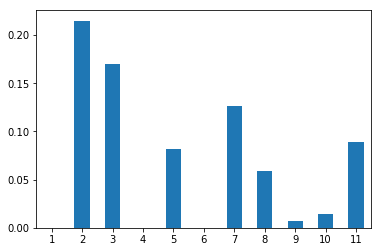

In [72]:
piece = df.iloc[0,-11:]
piece.plot.bar(rot=0);

## Step 5: Plot the averaged pitch class distribution for the major and the minor mode
2. Plot the averaged distributions. 
1. Can you show everything in one figure? 
3. Would it also make sense to plot averaged pitch class histograms?

In [73]:
melted = df.melt(id_vars='mode',
                 value_vars=[0,1,2,3,4,5,6,7,8,9,10,11],
                 var_name='pitch_classes',
                 value_name='relative_frequencies'
                )

In [74]:
melted.head()

,mode,pitch_classes,relative_frequencies
0,minor,0,0.237037
1,major,0,0.107692
2,major,0,0.114286
3,major,0,0.107692
4,major,0,0.114286


In [75]:
melted.shape

(112464, 3)

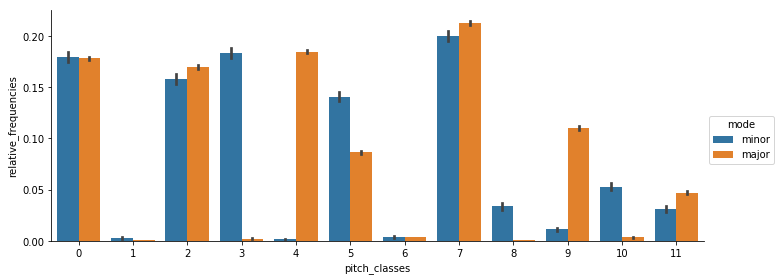

In [76]:
sns.factorplot(data=melted, 
               x='pitch_classes', 
               y='relative_frequencies', 
               hue='mode',
               kind='bar',
               aspect=2.5
              );

plt.show()

## Step 6: Plot the averaged distributions in fifths ordering
1. Create the plot.
2. What do you see?

In [77]:
melted['fifths'] = melted['pitch_classes'] * 7 % 12

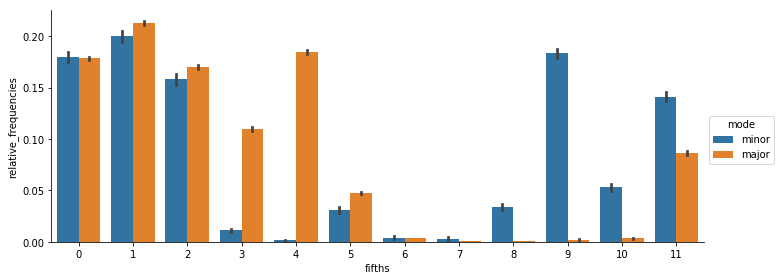

In [78]:
sns.factorplot(data=melted, 
               x='fifths', 
               y='relative_frequencies', 
               hue='mode',
               kind='bar',
               aspect=2.5
              );

## Step 7: Extend the plot above to show the diffusion of each pitch class
1. Decide to either use error bars, boxplots, or violin plots. What is the difference between them? Violin plots are of cause the most fancy figures... 
1. Describe what you see.

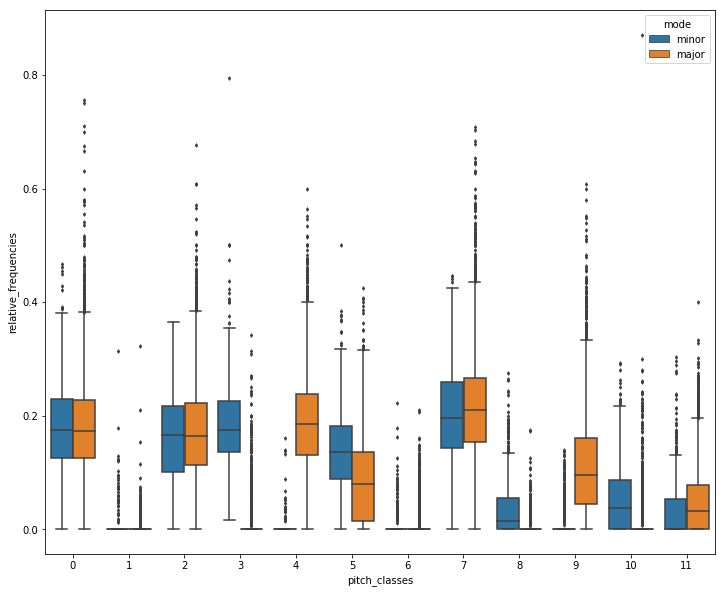

In [86]:
plt.figure(figsize=(12,10))
sns.boxplot(
    data=melted,
    x='pitch_classes',
    y='relative_frequencies',
    hue='mode',
    fliersize=2.5
);

These boxplots show already much more! For example, they reveal that there are many outliers which we can't see in the bar plot. 
https://www.autodeskresearch.com/publications/samestats

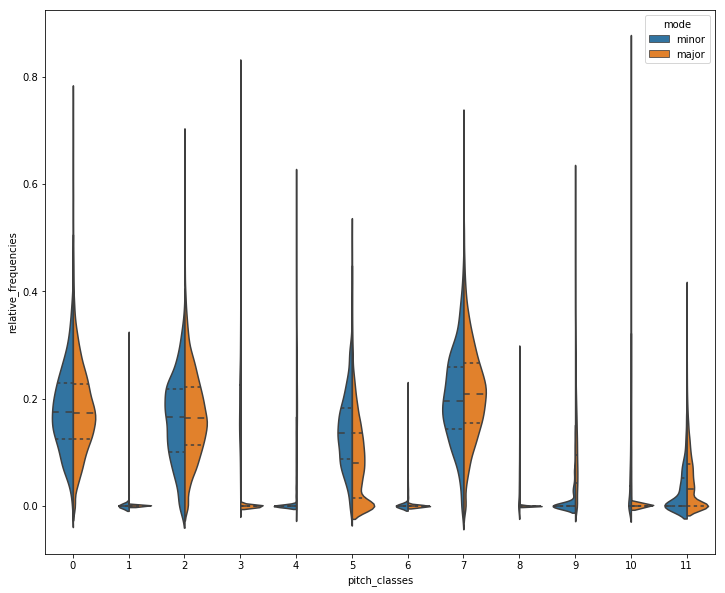

In [94]:
plt.figure(figsize=(12,10))
sns.violinplot(
    data=melted,
    x='pitch_classes',
    y='relative_frequencies',
    hue='mode',
    inner='quart',
    split=True
);